# OpenAudio S1-Mini LoRA Finetuning - Neymar Dataset

Production-grade notebook for finetuning OpenAudio S1-Mini on custom voice data using LoRA.

## Features
- **Data Validation**: Comprehensive checks for audio, text, and VQ tokens
- **VQ Token Analysis**: Codebook utilization and quality metrics
- **TensorBoard Integration**: Real-time training metrics visualization
- **Training Diagnostics**: Loss curves, accuracy plots, gradient monitoring
- **Quality Assessment**: A/B comparison between base and finetuned models

## Requirements
- CUDA-enabled GPU with 12GB+ VRAM (16GB recommended)
- Python 3.10+
- PyTorch 2.0+
- Dataset in Fish Speech format: `.wav`, `.lab`, `.npy` files

## Dataset Format (per official docs)
```
data/neymar_finetune/
├── NEY0001.wav    # Audio file
├── NEY0001.lab    # Text transcription
├── NEY0001.npy    # VQ tokens (10, N)
├── ...
└── protos/        # Protobuf dataset
```


In [ ]:
# Cell 1: Environment Setup
import os
import sys
import platform
from pathlib import Path
import subprocess
import shutil
import time
import json
from datetime import datetime
from typing import Optional

# Robust project root detection
def find_project_root() -> Path:
    """Find fish-speech project root using multiple methods."""
    # Method 1: Search upward from current directory
    current = Path(os.getcwd()).resolve()
    for _ in range(10):
        if (current / "fish_speech").exists():
            return current
        if current == current.parent:
            break
        current = current.parent
    
    # Method 2: Common locations
    common_paths = [
        Path.home() / "Desktop" / "fish-speech",
        Path.home() / "fish-speech",
        Path("/workspace/fish-speech"),
    ]
    for p in common_paths:
        if (p / "fish_speech").exists():
            return p
    
    # Method 3: Check sys.path
    for path in sys.path:
        p = Path(path).resolve()
        if (p / "fish_speech").exists():
            return p
        if (p.parent / "fish_speech").exists():
            return p.parent
    
    raise RuntimeError(f"Could not find fish_speech directory. CWD: {os.getcwd()}")

PROJECT_ROOT = find_project_root()
os.chdir(PROJECT_ROOT)
sys.path.insert(0, str(PROJECT_ROOT))

import torch
import numpy as np

print("=" * 70)
print("ENVIRONMENT SETUP")
print("=" * 70)
print(f"Project Root: {PROJECT_ROOT}")
print(f"Python: {sys.version.split()[0]}")
print(f"PyTorch: {torch.__version__}")
print(f"Platform: {platform.system()} {platform.release()}")

# GPU Detection
if torch.cuda.is_available():
    GPU_NAME = torch.cuda.get_device_name(0)
    VRAM_GB = torch.cuda.get_device_properties(0).total_memory / 1024**3
    print(f"GPU: {GPU_NAME}")
    print(f"VRAM: {VRAM_GB:.1f} GB")
    
    # Batch size recommendations
    if VRAM_GB >= 24:
        RECOMMENDED_BATCH = 8
    elif VRAM_GB >= 16:
        RECOMMENDED_BATCH = 4
    elif VRAM_GB >= 12:
        RECOMMENDED_BATCH = 2
    else:
        RECOMMENDED_BATCH = 1
    print(f"Recommended Batch Size: {RECOMMENDED_BATCH}")
else:
    print("[ERROR] No CUDA GPU detected!")
    VRAM_GB = 0
    RECOMMENDED_BATCH = 1

# Triton check (optional, for torch.compile acceleration)
try:
    import triton
    TRITON_AVAILABLE = True
    print(f"Triton: {triton.__version__} (torch.compile acceleration available)")
except ImportError:
    TRITON_AVAILABLE = False
    print("[INFO] Triton not available (inference will be slower, training unaffected)")

# Protobuf compatibility check
import google.protobuf
print(f"Protobuf: {google.protobuf.__version__}")

print("\n[OK] Environment ready")


ENVIRONMENT SETUP
Project Root: C:\Users\PC\Desktop\fish-speech
Python: 3.10.11
PyTorch: 2.9.1+cu130
Platform: Windows 10
GPU: NVIDIA GeForce RTX 5070 Ti
VRAM: 15.9 GB
Recommended Batch Size: 2
[INFO] Triton not available (inference will be slower, training unaffected)
Protobuf: 3.20.3

[OK] Environment ready


In [ ]:
# Cell 2: Dataset Configuration

# ============================================================================
# CONFIGURATION - EDIT THESE VALUES
# ============================================================================

# Dataset (already prepared with WAV, LAB, NPY files)
DATASET_NAME = "neymar_finetune"
DATASET_DIR = PROJECT_ROOT / "data" / DATASET_NAME

# Base model
BASE_MODEL_PATH = PROJECT_ROOT / "checkpoints" / "openaudio-s1-mini"
CODEC_PATH = BASE_MODEL_PATH / "codec.pth"

# Training hyperparameters
MAX_STEPS = 1000              # Total training steps
BATCH_SIZE = RECOMMENDED_BATCH if 'RECOMMENDED_BATCH' in dir() else 4
LEARNING_RATE = 1e-4          # AdamW learning rate
VAL_CHECK_INTERVAL = 100      # Validate every N steps
CHECKPOINT_INTERVAL = 100     # Save checkpoint every N steps

# LoRA configuration
LORA_R = 8                    # LoRA rank (lower = faster, higher = more capacity)
LORA_ALPHA = 16               # LoRA alpha (usually 2x rank)

# Output
PROJECT_NAME = f"{DATASET_NAME}_lora"
OUTPUT_MODEL = PROJECT_ROOT / "checkpoints" / f"openaudio-s1-mini-{DATASET_NAME}"
RESULTS_DIR = PROJECT_ROOT / "results" / PROJECT_NAME

# ============================================================================
# VALIDATION
# ============================================================================

print("=" * 70)
print("CONFIGURATION")
print("=" * 70)

errors = []

# Check dataset
if not DATASET_DIR.exists():
    errors.append(f"Dataset not found: {DATASET_DIR}")
else:
    wav_count = len(list(DATASET_DIR.glob("*.wav")))
    lab_count = len(list(DATASET_DIR.glob("*.lab")))
    npy_count = len(list(DATASET_DIR.glob("*.npy")))
    protos_dir = DATASET_DIR / "protos"
    
    print(f"Dataset: {DATASET_DIR}")
    print(f"  WAV files: {wav_count}")
    print(f"  LAB files: {lab_count}")
    print(f"  NPY files: {npy_count}")
    print(f"  Protos: {'[OK]' if protos_dir.exists() else '[MISSING]'}")
    
    if wav_count == 0:
        errors.append("No WAV files found in dataset")
    if npy_count == 0:
        errors.append("No NPY (VQ token) files found - run VQ extraction first")
    if not protos_dir.exists():
        errors.append("Protos directory missing - run protobuf build first")

# Check base model
if not BASE_MODEL_PATH.exists():
    errors.append(f"Base model not found: {BASE_MODEL_PATH}")
else:
    print(f"\nBase Model: {BASE_MODEL_PATH}")
    required_files = ["model.pth", "codec.pth", "config.json", "tokenizer.tiktoken"]
    for f in required_files:
        status = "[OK]" if (BASE_MODEL_PATH / f).exists() else "[MISSING]"
        print(f"  {f}: {status}")
        if status == "[MISSING]":
            errors.append(f"Missing base model file: {f}")

# Training config summary
print(f"\nTraining Configuration:")
print(f"  Max Steps: {MAX_STEPS}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  LoRA: r={LORA_R}, alpha={LORA_ALPHA}")
print(f"  Checkpoint Interval: {CHECKPOINT_INTERVAL} steps")

# Estimate training time (rough)
est_time_per_step = 3.0 if VRAM_GB < 16 else 2.0
est_total_time = MAX_STEPS * est_time_per_step / 60
print(f"  Estimated Time: ~{est_total_time:.0f} minutes")

print(f"\nOutput: {OUTPUT_MODEL}")

if errors:
    print("\n" + "=" * 70)
    print("ERRORS - Fix before proceeding:")
    for e in errors:
        print(f"  [!] {e}")
    raise RuntimeError("Configuration errors detected")
else:
    print("\n[OK] Configuration validated")


CONFIGURATION
Dataset: C:\Users\PC\Desktop\fish-speech\data\neymar_finetune
  WAV files: 742
  LAB files: 742
  NPY files: 742
  Protos: [OK]

Base Model: C:\Users\PC\Desktop\fish-speech\checkpoints\openaudio-s1-mini
  model.pth: [OK]
  codec.pth: [OK]
  config.json: [OK]
  tokenizer.tiktoken: [OK]

Training Configuration:
  Max Steps: 1000
  Batch Size: 2
  Learning Rate: 0.0001
  LoRA: r=8, alpha=16
  Checkpoint Interval: 100 steps
  Estimated Time: ~50 minutes

Output: C:\Users\PC\Desktop\fish-speech\checkpoints\openaudio-s1-mini-neymar_finetune

[OK] Configuration validated


In [ ]:
# Cell 3: Data Validation & Diagnostics
import soundfile as sf
from collections import defaultdict

print("=" * 70)
print("DATA VALIDATION & DIAGNOSTICS")
print("=" * 70)

# Collect all samples
wav_files = sorted(DATASET_DIR.glob("*.wav"))
samples = []
issues = defaultdict(list)

print(f"\nValidating {len(wav_files)} samples...")

for wav_path in wav_files:
    sample_id = wav_path.stem
    lab_path = DATASET_DIR / f"{sample_id}.lab"
    npy_path = DATASET_DIR / f"{sample_id}.npy"
    
    sample = {"id": sample_id, "wav": wav_path}
    
    # Check LAB file
    if lab_path.exists():
        sample["lab"] = lab_path
        text = lab_path.read_text(encoding="utf-8").strip()
        sample["text"] = text
        sample["text_len"] = len(text)
        if len(text) < 5:
            issues["short_text"].append(sample_id)
    else:
        issues["missing_lab"].append(sample_id)
        sample["lab"] = None
        sample["text"] = ""
        sample["text_len"] = 0
    
    # Check NPY file
    if npy_path.exists():
        sample["npy"] = npy_path
        try:
            vq = np.load(npy_path)
            sample["vq_shape"] = vq.shape
            sample["vq_min"] = int(vq.min())
            sample["vq_max"] = int(vq.max())
            sample["vq_zeros"] = float((vq == 0).sum() / vq.size)
            
            # Validate shape
            if vq.shape[0] != 10:
                issues["wrong_codebooks"].append(f"{sample_id}: {vq.shape[0]} codebooks")
            
            # Validate range
            if vq.max() >= 4096:
                issues["vq_out_of_range"].append(f"{sample_id}: max={vq.max()}")
                
        except Exception as e:
            issues["corrupt_npy"].append(f"{sample_id}: {e}")
            sample["vq_shape"] = None
    else:
        issues["missing_npy"].append(sample_id)
        sample["npy"] = None
        sample["vq_shape"] = None
    
    # Check audio properties
    try:
        info = sf.info(str(wav_path))
        sample["duration"] = info.duration
        sample["sample_rate"] = info.samplerate
        sample["channels"] = info.channels
        
        if info.samplerate != 44100:
            issues["wrong_sample_rate"].append(f"{sample_id}: {info.samplerate}Hz")
        if info.duration < 0.5:
            issues["short_audio"].append(f"{sample_id}: {info.duration:.2f}s")
        if info.duration > 30:
            issues["long_audio"].append(f"{sample_id}: {info.duration:.2f}s")
            
    except Exception as e:
        issues["corrupt_audio"].append(f"{sample_id}: {e}")
        sample["duration"] = 0
        sample["sample_rate"] = 0
    
    samples.append(sample)

# Summary statistics
valid_samples = [s for s in samples if s.get("npy") and s.get("lab")]
durations = [s["duration"] for s in valid_samples if s.get("duration", 0) > 0]
text_lengths = [s["text_len"] for s in valid_samples if s.get("text_len", 0) > 0]

print(f"\n{'='*40}")
print("SUMMARY")
print(f"{'='*40}")
print(f"Total samples: {len(samples)}")
print(f"Valid samples (WAV+LAB+NPY): {len(valid_samples)}")

if durations:
    print(f"\nAudio Duration:")
    print(f"  Total: {sum(durations)/60:.1f} minutes")
    print(f"  Range: {min(durations):.1f}s - {max(durations):.1f}s")
    print(f"  Mean: {np.mean(durations):.1f}s")

if text_lengths:
    print(f"\nText Length:")
    print(f"  Range: {min(text_lengths)} - {max(text_lengths)} chars")
    print(f"  Mean: {np.mean(text_lengths):.0f} chars")

# Report issues
if any(issues.values()):
    print(f"\n{'='*40}")
    print("ISSUES DETECTED")
    print(f"{'='*40}")
    for issue_type, items in issues.items():
        if items:
            print(f"\n{issue_type} ({len(items)}):")
            for item in items[:5]:  # Show first 5
                print(f"  - {item}")
            if len(items) > 5:
                print(f"  ... and {len(items)-5} more")
else:
    print("\n[OK] No issues detected")

# Store for later use
VALIDATION_DATA = {
    "samples": samples,
    "valid_count": len(valid_samples),
    "total_duration_min": sum(durations) / 60 if durations else 0,
    "issues": dict(issues),
}


DATA VALIDATION & DIAGNOSTICS

Validating 742 samples...

SUMMARY
Total samples: 742
Valid samples (WAV+LAB+NPY): 742

Audio Duration:
  Total: 77.4 minutes
  Range: 3.0s - 15.0s
  Mean: 6.3s

Text Length:
  Range: 25 - 285 chars
  Mean: 92 chars

[OK] No issues detected


VQ TOKEN QUALITY ANALYSIS
Analyzing 742 VQ token files...

Codebook   Unique Values   Zero %     Max Value 
--------------------------------------------------
0          3653            0.0        4095       [OK]
1          931             0.0        1022       [OK]
2          1024            0.1        1023       [OK]
3          1024            0.1        1023       [OK]
4          1023            0.1        1023       [OK]
5          1024            0.1        1023       [OK]
6          1024            0.1        1023       [OK]
7          1024            0.1        1023       [OK]
8          1024            0.1        1023       [OK]
9          1024            0.1        1023       [OK]

VQ Token Lengths:
  Range: 65 - 323 tokens
  Mean: 135 tokens
  Median: 122 tokens

[OK] All samples have healthy VQ token distributions


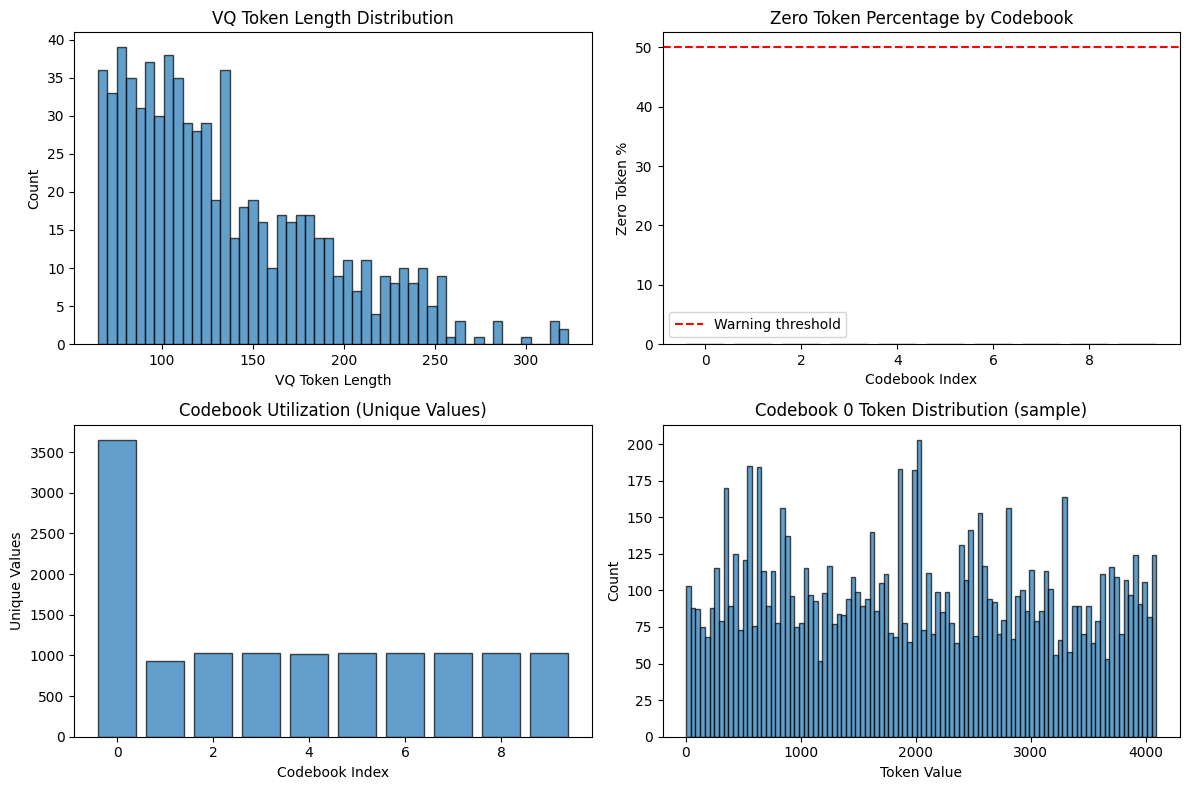


[OK] VQ analysis complete


In [ ]:
# Cell 4: VQ Token Quality Analysis
import matplotlib.pyplot as plt

print("=" * 70)
print("VQ TOKEN QUALITY ANALYSIS")
print("=" * 70)

# Analyze VQ tokens across all samples
codebook_stats = {i: {"values": [], "zeros": 0, "total": 0} for i in range(10)}
vq_lengths = []
problematic_samples = []

npy_files = list(DATASET_DIR.glob("*.npy"))
print(f"Analyzing {len(npy_files)} VQ token files...")

for npy_path in npy_files:
    try:
        vq = np.load(npy_path)
        if vq.shape[0] != 10:
            continue
            
        vq_lengths.append(vq.shape[1])
        
        for i in range(10):
            codebook = vq[i]
            codebook_stats[i]["values"].extend(codebook.flatten().tolist())
            codebook_stats[i]["zeros"] += (codebook == 0).sum()
            codebook_stats[i]["total"] += codebook.size
            
        # Check for problematic samples
        zero_ratio = (vq == 0).sum() / vq.size
        if zero_ratio > 0.5:
            problematic_samples.append((npy_path.stem, zero_ratio))
            
    except Exception as e:
        print(f"Error loading {npy_path.name}: {e}")

# Print codebook statistics
print(f"\n{'Codebook':<10} {'Unique Values':<15} {'Zero %':<10} {'Max Value':<10}")
print("-" * 50)

for i in range(10):
    values = codebook_stats[i]["values"]
    if values:
        unique = len(set(values))
        zero_pct = codebook_stats[i]["zeros"] / codebook_stats[i]["total"] * 100
        max_val = max(values)
        status = "[WARN]" if zero_pct > 50 else "[OK]"
        print(f"{i:<10} {unique:<15} {zero_pct:<10.1f} {max_val:<10} {status}")

# VQ token length distribution
if vq_lengths:
    print(f"\nVQ Token Lengths:")
    print(f"  Range: {min(vq_lengths)} - {max(vq_lengths)} tokens")
    print(f"  Mean: {np.mean(vq_lengths):.0f} tokens")
    print(f"  Median: {np.median(vq_lengths):.0f} tokens")

# Problematic samples
if problematic_samples:
    print(f"\n[WARN] Samples with >50% zero tokens ({len(problematic_samples)}):")
    for sample_id, zero_ratio in problematic_samples[:10]:
        print(f"  - {sample_id}: {zero_ratio*100:.1f}% zeros")
else:
    print(f"\n[OK] All samples have healthy VQ token distributions")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1. VQ token length histogram
ax = axes[0, 0]
ax.hist(vq_lengths, bins=50, edgecolor='black', alpha=0.7)
ax.set_xlabel('VQ Token Length')
ax.set_ylabel('Count')
ax.set_title('VQ Token Length Distribution')

# 2. Zero percentage per codebook
ax = axes[0, 1]
zero_pcts = [codebook_stats[i]["zeros"] / codebook_stats[i]["total"] * 100 
             if codebook_stats[i]["total"] > 0 else 0 for i in range(10)]
ax.bar(range(10), zero_pcts, edgecolor='black', alpha=0.7)
ax.set_xlabel('Codebook Index')
ax.set_ylabel('Zero Token %')
ax.set_title('Zero Token Percentage by Codebook')
ax.axhline(y=50, color='r', linestyle='--', label='Warning threshold')
ax.legend()

# 3. Unique values per codebook
ax = axes[1, 0]
unique_counts = [len(set(codebook_stats[i]["values"])) for i in range(10)]
ax.bar(range(10), unique_counts, edgecolor='black', alpha=0.7)
ax.set_xlabel('Codebook Index')
ax.set_ylabel('Unique Values')
ax.set_title('Codebook Utilization (Unique Values)')

# 4. Sample token distribution (first codebook)
ax = axes[1, 1]
if codebook_stats[0]["values"]:
    sample_values = codebook_stats[0]["values"][:10000]  # Sample for performance
    ax.hist(sample_values, bins=100, edgecolor='black', alpha=0.7)
ax.set_xlabel('Token Value')
ax.set_ylabel('Count')
ax.set_title('Codebook 0 Token Distribution (sample)')

plt.tight_layout()
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
plt.savefig(RESULTS_DIR / "vq_analysis.png", dpi=100)
plt.show()

print("\n[OK] VQ analysis complete")


In [ ]:
# Cell 5: TensorBoard Setup

print("=" * 70)
print("TENSORBOARD SETUP")
print("=" * 70)

TENSORBOARD_DIR = RESULTS_DIR / "tensorboard"

# Create results directory
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Option to clear previous logs
CLEAR_PREVIOUS_LOGS = False  # Set to True to start fresh

if CLEAR_PREVIOUS_LOGS and TENSORBOARD_DIR.exists():
    shutil.rmtree(TENSORBOARD_DIR)
    print(f"[INFO] Cleared previous TensorBoard logs")

TENSORBOARD_DIR.mkdir(parents=True, exist_ok=True)
print(f"TensorBoard directory: {TENSORBOARD_DIR}")

# Try to load TensorBoard in notebook
try:
    from tensorboard import notebook
    notebook.list()
    print("\n[INFO] TensorBoard can be started with: %tensorboard --logdir {TENSORBOARD_DIR}")
except ImportError:
    print("[INFO] TensorBoard notebook extension not available")
    print(f"       Run in terminal: tensorboard --logdir {TENSORBOARD_DIR}")

# Check for existing event files
event_files = list(TENSORBOARD_DIR.rglob("events.out.tfevents.*"))
if event_files:
    print(f"\n[INFO] Found {len(event_files)} existing TensorBoard event file(s)")
    latest = max(event_files, key=lambda p: p.stat().st_mtime)
    print(f"       Latest: {latest.name}")

print(f"\n[OK] TensorBoard configured")
print(f"\nTo view metrics during training, run in a separate terminal:")
print(f"  tensorboard --logdir \"{TENSORBOARD_DIR}\"")


TENSORBOARD SETUP
TensorBoard directory: C:\Users\PC\Desktop\fish-speech\results\neymar_finetune_lora\tensorboard
No known TensorBoard instances running.

[INFO] TensorBoard can be started with: %tensorboard --logdir {TENSORBOARD_DIR}

[OK] TensorBoard configured

To view metrics during training, run in a separate terminal:
  tensorboard --logdir "C:\Users\PC\Desktop\fish-speech\results\neymar_finetune_lora\tensorboard"


In [ ]:
# Cell 6: Training Configuration Validation

print("=" * 70)
print("TRAINING CONFIGURATION VALIDATION")
print("=" * 70)

# Check LoRA config exists
lora_config_path = PROJECT_ROOT / "fish_speech" / "configs" / "lora" / f"r_{LORA_R}_alpha_{LORA_ALPHA}.yaml"
if not lora_config_path.exists():
    print(f"[WARN] LoRA config not found: {lora_config_path}")
    print("       Using default LoRA config pattern")
else:
    print(f"[OK] LoRA config: r_{LORA_R}_alpha_{LORA_ALPHA}")

# Estimate memory requirements
base_model_size_gb = 3.0
lora_overhead_gb = 0.5
activation_memory_per_batch = 2.0
estimated_memory = base_model_size_gb + lora_overhead_gb + (activation_memory_per_batch * BATCH_SIZE)

print(f"\nMemory Estimation:")
print(f"  Base model: ~{base_model_size_gb:.1f} GB")
print(f"  LoRA adapters: ~{lora_overhead_gb:.1f} GB")
print(f"  Activations (batch={BATCH_SIZE}): ~{activation_memory_per_batch * BATCH_SIZE:.1f} GB")
print(f"  Total estimated: ~{estimated_memory:.1f} GB")

if VRAM_GB > 0:
    if estimated_memory > VRAM_GB * 0.9:
        print(f"  [WARN] May exceed available VRAM ({VRAM_GB:.1f} GB)")
        print(f"         Consider reducing BATCH_SIZE to {max(1, BATCH_SIZE // 2)}")
    else:
        print(f"  [OK] Should fit in {VRAM_GB:.1f} GB VRAM")

# Check protobuf dataset
protos_dir = DATASET_DIR / "protos"
if protos_dir.exists():
    proto_files = list(protos_dir.glob("*.protos"))
    total_size = sum(f.stat().st_size for f in proto_files)
    print(f"\nProtobuf Dataset:")
    print(f"  Files: {len(proto_files)}")
    print(f"  Size: {total_size / 1024 / 1024:.1f} MB")
else:
    print(f"\n[ERROR] Protobuf dataset not found at {protos_dir}")
    print("        Run the protobuf build step first")

# Training command preview
print(f"\nTraining Command Preview:")
# Use forward slashes for Hydra on Windows
protos_preview = str(DATASET_DIR / 'protos').replace('\\', '/')
cmd_preview = [
    "python fish_speech/train.py",
    "--config-name text2semantic_finetune",
    f"project={PROJECT_NAME}",
    f"trainer.max_steps={MAX_STEPS}",
    f"trainer.val_check_interval={VAL_CHECK_INTERVAL}",
    f"data.batch_size={BATCH_SIZE}",
    f"model.optimizer.lr={LEARNING_RATE}",
    f"+lora@model.model.lora_config=r_{LORA_R}_alpha_{LORA_ALPHA}",
    f"train_dataset.proto_files=[{protos_preview}]",
]
if platform.system() == 'Windows':
    cmd_preview.append("trainer.strategy=auto")
    cmd_preview.append("trainer.devices=1")

for line in cmd_preview:
    print(f"  {line}")

print(f"\n[OK] Ready to train")


TRAINING CONFIGURATION VALIDATION
[OK] LoRA config: r_8_alpha_16

Memory Estimation:
  Base model: ~3.0 GB
  LoRA adapters: ~0.5 GB
  Activations (batch=2): ~4.0 GB
  Total estimated: ~7.5 GB
  [OK] Should fit in 15.9 GB VRAM

Protobuf Dataset:
  Files: 1
  Size: 1.5 MB

Training Command Preview:
  python fish_speech/train.py
  --config-name text2semantic_finetune
  project=neymar_finetune_lora
  trainer.max_steps=1000
  trainer.val_check_interval=100
  data.batch_size=2
  model.optimizer.lr=0.0001
  +lora@model.model.lora_config=r_8_alpha_16
  train_dataset.proto_files=[C:/Users/PC/Desktop/fish-speech/data/neymar_finetune/protos]
  trainer.strategy=auto
  trainer.devices=1

[OK] Ready to train


In [ ]:
# Cell 7: LoRA Training with Live Metrics
import re

print("=" * 70)
print("LoRA TRAINING")
print("=" * 70)

# Clear existing checkpoints to prevent auto-resume issues
ckpt_dir = RESULTS_DIR / "checkpoints"
if ckpt_dir.exists():
    print(f"[INFO] Removing existing checkpoints for fresh training...")
    shutil.rmtree(ckpt_dir)

# Build training command
# Use forward slashes for Hydra compatibility on Windows
protos_path = str(DATASET_DIR / 'protos').replace('\\', '/')

cmd = [
    sys.executable,
    "fish_speech/train.py",
    "--config-name", "text2semantic_finetune",
    f"project={PROJECT_NAME}",
    f"trainer.max_steps={MAX_STEPS}",
    f"trainer.val_check_interval={VAL_CHECK_INTERVAL}",
    f"callbacks.model_checkpoint.every_n_train_steps={CHECKPOINT_INTERVAL}",
    f"data.batch_size={BATCH_SIZE}",
    f"model.optimizer.lr={LEARNING_RATE}",
    f"+lora@model.model.lora_config=r_{LORA_R}_alpha_{LORA_ALPHA}",
    # Override data path to use our dataset (forward slashes for Hydra)
    f"train_dataset.proto_files=[{protos_path}]",
    f"val_dataset.proto_files=[{protos_path}]",
]

# Windows-specific adjustments
if platform.system() == 'Windows':
    cmd.extend(["trainer.strategy=auto", "trainer.devices=1"])

print(f"Starting training: {MAX_STEPS} steps, batch_size={BATCH_SIZE}")
print(f"Checkpoints will be saved every {CHECKPOINT_INTERVAL} steps")
print("\n" + "-" * 70)

# Training metrics tracking
training_log = {
    "start_time": datetime.now().isoformat(),
    "config": {
        "max_steps": MAX_STEPS,
        "batch_size": BATCH_SIZE,
        "learning_rate": LEARNING_RATE,
        "lora_r": LORA_R,
        "lora_alpha": LORA_ALPHA,
    },
    "metrics": [],
}

start_time = time.time()
last_step = 0
last_loss = None

process = subprocess.Popen(
    cmd,
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True,
    encoding='utf-8',
    errors='replace',
    bufsize=1,
    cwd=str(PROJECT_ROOT),
)

# Parse output for metrics
step_pattern = re.compile(r"step[=: ](\d+)")
loss_pattern = re.compile(r"train/loss[=: ]([\d.]+)")

if process.stdout:
    for line in process.stdout:
        print(line, end="")
        
        # Extract metrics from log lines
        step_match = step_pattern.search(line)
        loss_match = loss_pattern.search(line)
        
        if step_match:
            last_step = int(step_match.group(1))
        if loss_match:
            last_loss = float(loss_match.group(1))
            training_log["metrics"].append({
                "step": last_step,
                "loss": last_loss,
                "time": time.time() - start_time,
            })
else:
    stdout, _ = process.communicate()
    if stdout:
        print(stdout)

process.wait()
elapsed = time.time() - start_time

training_log["end_time"] = datetime.now().isoformat()
training_log["elapsed_seconds"] = elapsed
training_log["exit_code"] = process.returncode

# Save training log
log_path = RESULTS_DIR / "training_log.json"
with open(log_path, "w") as f:
    json.dump(training_log, f, indent=2)

print("\n" + "-" * 70)
if process.returncode == 0:
    print(f"[OK] Training completed in {elapsed/60:.1f} minutes")
    print(f"     Final step: {last_step}")
    if last_loss:
        print(f"     Final loss: {last_loss:.4f}")
    print(f"     Log saved: {log_path}")
else:
    print(f"[ERROR] Training failed with exit code {process.returncode}")
    print("        Check the output above for error details")


LoRA TRAINING
Starting training: 1000 steps, batch_size=2
Checkpoints will be saved every 100 steps

----------------------------------------------------------------------
[2025-12-19 21:28:03,070][__main__][INFO] - [rank: 0] Instantiating datamodule <fish_speech.datasets.semantic.SemanticDataModule>
[2025-12-19 21:28:03,297][datasets][INFO] - PyTorch version 2.9.1+cu130 available.
[2025-12-19 21:28:04,101][__main__][INFO] - [rank: 0] Instantiating model <fish_speech.models.text2semantic.lit_module.TextToSemantic>
2025-12-19 21:28:04.115 | INFO     | fish_speech.models.text2semantic.llama:from_pretrained:416 - Override max_seq_len to 4096
2025-12-19 21:28:04.387 | INFO     | fish_speech.models.text2semantic.llama:from_pretrained:432 - Loading model from checkpoints/openaudio-s1-mini, config: DualARModelArgs(model_type='dual_ar', vocab_size=155776, n_layer=28, n_head=16, dim=1024, intermediate_size=3072, n_local_heads=8, head_dim=128, rope_base=1000000, norm_eps=1e-06, max_seq_len=4096,

TRAINING DIAGNOSTICS
Found 4 event file(s)
Loading: events.out.tfevents.1766176094.bruce.31988.0

Available metrics: ['hp_metric', 'lr-AdamW/pg1', 'lr-AdamW/pg2', 'train/loss', 'train/base_loss', 'train/semantic_loss', 'train/top_5_accuracy', 'train/grad_norm', 'epoch', 'val/loss', 'val/base_loss', 'val/semantic_loss', 'val/top_5_accuracy']
[INFO] Loss is stable - may need more training steps
[WARN] Final accuracy: 2.12% (may need more training)
[OK] Gradient norm healthy (range: 5.22 - 12.25)


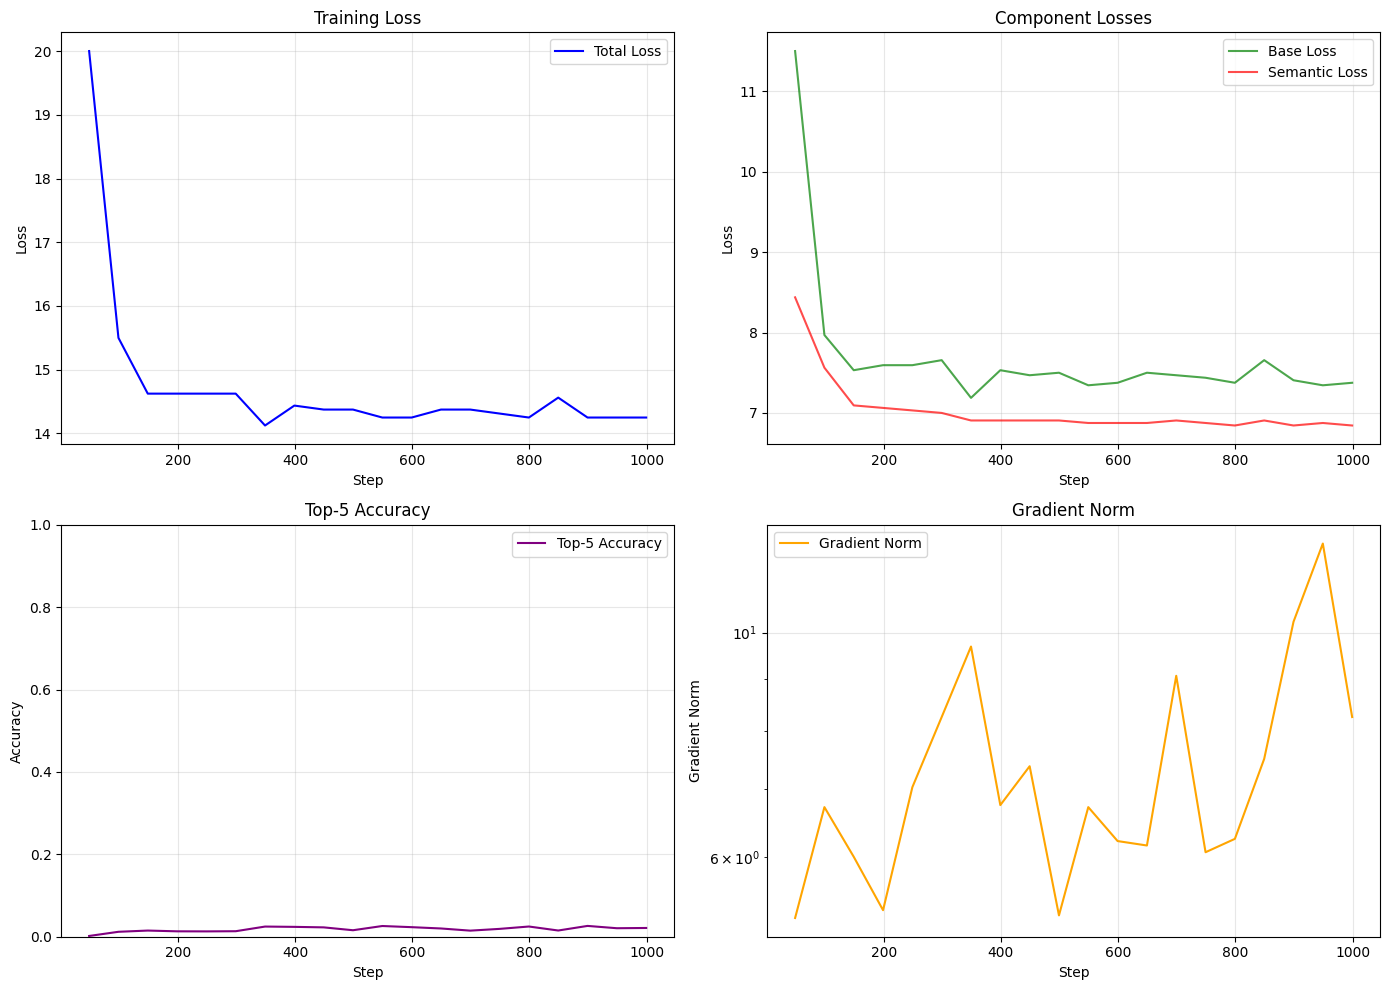


Plot saved: C:\Users\PC\Desktop\fish-speech\results\neymar_finetune_lora\training_metrics.png

Checkpoints (5):
  step_000000600.ckpt (46.6 MB)
  step_000000700.ckpt (46.6 MB)
  step_000000800.ckpt (46.6 MB)
  step_000000900.ckpt (46.6 MB)
  step_000001000.ckpt (46.6 MB)


In [ ]:
# Cell 8: Training Diagnostics
import matplotlib.pyplot as plt

print("=" * 70)
print("TRAINING DIAGNOSTICS")
print("=" * 70)

# Try to load TensorBoard data
try:
    from tensorboard.backend.event_processing import event_accumulator
    TB_AVAILABLE = True
except ImportError:
    TB_AVAILABLE = False
    print("[WARN] tensorboard not installed - using training log instead")

# Find TensorBoard event files
event_files = list(TENSORBOARD_DIR.rglob("events.out.tfevents.*")) if TENSORBOARD_DIR.exists() else []
metrics = {}

if TB_AVAILABLE and event_files:
    print(f"Found {len(event_files)} event file(s)")
    
    # Load the latest event file
    latest_event = max(event_files, key=lambda p: p.stat().st_mtime)
    print(f"Loading: {latest_event.name}")
    
    ea = event_accumulator.EventAccumulator(
        str(latest_event.parent),
        size_guidance={event_accumulator.SCALARS: 0}
    )
    ea.Reload()
    
    scalar_tags = ea.Tags().get('scalars', [])
    print(f"\nAvailable metrics: {scalar_tags}")
    
    for tag in ['train/loss', 'train/base_loss', 'train/semantic_loss', 
                'train/top_5_accuracy', 'train/grad_norm']:
        if tag in scalar_tags:
            events = ea.Scalars(tag)
            metrics[tag] = {
                'steps': [e.step for e in events],
                'values': [e.value for e in events],
            }
else:
    # Fallback to training log
    log_path = RESULTS_DIR / "training_log.json"
    if log_path.exists():
        with open(log_path) as f:
            training_log = json.load(f)
        if training_log.get("metrics"):
            metrics['train/loss'] = {
                'steps': [m['step'] for m in training_log['metrics']],
                'values': [m['loss'] for m in training_log['metrics']],
            }
            print(f"Loaded {len(training_log['metrics'])} metrics from training log")
    else:
        print("[WARN] No training data found")

if metrics:
    # Plot metrics
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Total Loss
    ax = axes[0, 0]
    if 'train/loss' in metrics:
        ax.plot(metrics['train/loss']['steps'], metrics['train/loss']['values'], 'b-', label='Total Loss')
        ax.set_xlabel('Step')
        ax.set_ylabel('Loss')
        ax.set_title('Training Loss')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        values = metrics['train/loss']['values']
        if len(values) > 10:
            first_10 = np.mean(values[:10])
            last_10 = np.mean(values[-10:])
            if last_10 < first_10 * 0.8:
                print("[OK] Loss is decreasing (training is working)")
            elif last_10 > first_10:
                print("[WARN] Loss is increasing - check data quality or reduce LR")
            else:
                print("[INFO] Loss is stable - may need more training steps")
    
    # 2. Component Losses
    ax = axes[0, 1]
    if 'train/base_loss' in metrics:
        ax.plot(metrics['train/base_loss']['steps'], metrics['train/base_loss']['values'], 
                'g-', label='Base Loss', alpha=0.7)
    if 'train/semantic_loss' in metrics:
        ax.plot(metrics['train/semantic_loss']['steps'], metrics['train/semantic_loss']['values'],
                'r-', label='Semantic Loss', alpha=0.7)
    ax.set_xlabel('Step')
    ax.set_ylabel('Loss')
    ax.set_title('Component Losses')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. Accuracy
    ax = axes[1, 0]
    if 'train/top_5_accuracy' in metrics:
        ax.plot(metrics['train/top_5_accuracy']['steps'], metrics['train/top_5_accuracy']['values'],
                'purple', label='Top-5 Accuracy')
        ax.set_xlabel('Step')
        ax.set_ylabel('Accuracy')
        ax.set_title('Top-5 Accuracy')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 1)
        
        values = metrics['train/top_5_accuracy']['values']
        if values:
            final_acc = values[-1]
            if final_acc > 0.5:
                print(f"[OK] Final accuracy: {final_acc:.2%} (good)")
            elif final_acc > 0.3:
                print(f"[INFO] Final accuracy: {final_acc:.2%} (acceptable)")
            else:
                print(f"[WARN] Final accuracy: {final_acc:.2%} (may need more training)")
    
    # 4. Gradient Norm
    ax = axes[1, 1]
    if 'train/grad_norm' in metrics:
        ax.plot(metrics['train/grad_norm']['steps'], metrics['train/grad_norm']['values'],
                'orange', label='Gradient Norm')
        ax.set_xlabel('Step')
        ax.set_ylabel('Gradient Norm')
        ax.set_title('Gradient Norm')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_yscale('log')
        
        values = metrics['train/grad_norm']['values']
        if values:
            max_grad = max(values)
            min_grad = min(values)
            if max_grad > 100:
                print(f"[WARN] Gradient explosion detected (max={max_grad:.1f}) - reduce LR")
            elif min_grad < 1e-6:
                print(f"[WARN] Gradient vanishing detected (min={min_grad:.2e})")
            else:
                print(f"[OK] Gradient norm healthy (range: {min_grad:.2f} - {max_grad:.2f})")
    
    plt.tight_layout()
    plot_path = RESULTS_DIR / "training_metrics.png"
    plt.savefig(plot_path, dpi=150)
    plt.show()
    print(f"\nPlot saved: {plot_path}")

# List checkpoints
ckpt_dir = RESULTS_DIR / "checkpoints"
if ckpt_dir.exists():
    checkpoints = sorted(ckpt_dir.glob("*.ckpt"))
    print(f"\nCheckpoints ({len(checkpoints)}):")
    for ckpt in checkpoints:
        size_mb = ckpt.stat().st_size / 1024 / 1024
        print(f"  {ckpt.name} ({size_mb:.1f} MB)")
else:
    print("\n[WARN] No checkpoints found")


In [ ]:
# Cell 9: Checkpoint Selection & Merge

print("=" * 70)
print("CHECKPOINT SELECTION & MERGE")
print("=" * 70)

ckpt_dir = RESULTS_DIR / "checkpoints"

if not ckpt_dir.exists():
    print("[ERROR] No checkpoints found. Run training first.")
else:
    checkpoints = sorted(ckpt_dir.glob("*.ckpt"))
    
    if not checkpoints:
        print("[ERROR] No checkpoint files found")
    else:
        print(f"Available checkpoints ({len(checkpoints)}):")
        for i, ckpt in enumerate(checkpoints):
            size_mb = ckpt.stat().st_size / 1024 / 1024
            print(f"  [{i}] {ckpt.name} ({size_mb:.1f} MB)")
        
        # Select checkpoint (default: latest)
        SELECTED_CHECKPOINT_INDEX = -1  # -1 = latest, or specify index
        selected_ckpt = checkpoints[SELECTED_CHECKPOINT_INDEX]
        print(f"\nSelected: {selected_ckpt.name}")
        
        # Merge LoRA weights
        print(f"\nMerging LoRA weights...")
        
        merge_cmd = [
            sys.executable,
            "tools/llama/merge_lora.py",
            "--lora-config", f"r_{LORA_R}_alpha_{LORA_ALPHA}",
            "--base-weight", str(BASE_MODEL_PATH),
            "--lora-weight", str(selected_ckpt),
            "--output", str(OUTPUT_MODEL),
        ]
        
        result = subprocess.run(
            merge_cmd,
            capture_output=True,
            text=True,
            encoding='utf-8',
            errors='replace',
            cwd=str(PROJECT_ROOT),
        )
        
        if result.returncode == 0:
            print(f"[OK] Model merged successfully")
            print(f"     Output: {OUTPUT_MODEL}")
            
            print(f"\n     Files:")
            for f in sorted(OUTPUT_MODEL.iterdir()):
                size = f.stat().st_size / 1024 / 1024
                print(f"       {f.name} ({size:.1f} MB)")
            
            if "Merged model is different from the original" in result.stdout:
                print(f"\n     [OK] Merge validation passed")
            elif "seems identical to the original" in result.stdout:
                print(f"\n     [WARN] Model may not have learned - check training")
        else:
            print(f"[ERROR] Merge failed")
            print(result.stderr)


CHECKPOINT SELECTION & MERGE
Available checkpoints (5):
  [0] step_000000600.ckpt (46.6 MB)
  [1] step_000000700.ckpt (46.6 MB)
  [2] step_000000800.ckpt (46.6 MB)
  [3] step_000000900.ckpt (46.6 MB)
  [4] step_000001000.ckpt (46.6 MB)

Selected: step_000001000.ckpt

Merging LoRA weights...
[OK] Model merged successfully
     Output: C:\Users\PC\Desktop\fish-speech\checkpoints\openaudio-s1-mini-neymar_finetune

     Files:
       config.json (0.0 MB)
       model.pth (3281.2 MB)
       special_tokens.json (0.1 MB)
       tokenizer.tiktoken (2.6 MB)


In [ ]:
# Cell 10: Post-Training Quality Assessment
from IPython.display import Audio, display

print("=" * 70)
print("POST-TRAINING QUALITY ASSESSMENT")
print("=" * 70)

# Test texts
TEST_TEXTS = [
    "Hello, this is a test of the finetuned voice model.",
    "The quick brown fox jumps over the lazy dog.",
]

# Output directory
test_output_dir = RESULTS_DIR / "test_outputs"
test_output_dir.mkdir(exist_ok=True)

def generate_audio(model_path: Path, text: str, output_name: str) -> Optional[Path]:
    """Generate audio from text using the specified model."""
    output_dir = test_output_dir / output_name
    output_dir.mkdir(exist_ok=True)
    
    # Generate semantic tokens
    result = subprocess.run(
        [
            sys.executable,
            "fish_speech/models/text2semantic/inference.py",
            "--text", text,
            "--checkpoint-path", str(model_path),
            "--max-new-tokens", "500",
            "--output-dir", str(output_dir),
        ],
        capture_output=True,
        text=True,
        encoding='utf-8',
        errors='replace',
        cwd=str(PROJECT_ROOT),
    )
    
    if result.returncode != 0:
        print(f"  [ERROR] Text2semantic failed: {result.stderr[-200:] if result.stderr else 'Unknown'}")
        return None
    
    # Decode to audio
    codes_file = output_dir / "codes_0.npy"
    if not codes_file.exists():
        print(f"  [ERROR] Codes file not generated")
        return None
    
    output_wav = output_dir / "output.wav"
    result = subprocess.run(
        [
            sys.executable,
            "fish_speech/models/dac/inference.py",
            "-i", str(codes_file),
            "--checkpoint-path", str(CODEC_PATH),
            "-o", str(output_wav),
        ],
        capture_output=True,
        text=True,
        encoding='utf-8',
        errors='replace',
        cwd=str(PROJECT_ROOT),
    )
    
    if result.returncode == 0 and output_wav.exists():
        return output_wav
    else:
        print(f"  [ERROR] DAC decode failed")
        return None

# Generate comparisons
print("\nGenerating A/B comparison...")
print(f"Test text: \"{TEST_TEXTS[0]}\"")
print()

# Base model
print("Generating with BASE model...")
start = time.time()
base_audio = generate_audio(BASE_MODEL_PATH, TEST_TEXTS[0], "base")
base_time = time.time() - start

if base_audio:
    print(f"  [OK] Generated in {base_time:.1f}s")
    print(f"\n  Base Model Output:")
    display(Audio(filename=str(base_audio)))

# Finetuned model
print("\nGenerating with FINETUNED model...")
start = time.time()
finetuned_audio = generate_audio(OUTPUT_MODEL, TEST_TEXTS[0], "finetuned")
finetuned_time = time.time() - start

if finetuned_audio:
    print(f"  [OK] Generated in {finetuned_time:.1f}s")
    print(f"\n  Finetuned Model Output:")
    display(Audio(filename=str(finetuned_audio)))

# Summary
print("\n" + "=" * 70)
print("COMPARISON SUMMARY")
print("=" * 70)
print(f"Base model:      {BASE_MODEL_PATH.name}")
print(f"Finetuned model: {OUTPUT_MODEL.name}")
print(f"\nListen to both outputs above and compare:")
print("- Voice characteristics (timbre, pitch)")
print("- Pronunciation clarity")
print("- Natural prosody and rhythm")
print(f"\nOutputs saved to: {test_output_dir}")


POST-TRAINING QUALITY ASSESSMENT

Generating A/B comparison...
Test text: "Hello, this is a test of the finetuned voice model."

Generating with BASE model...
  [OK] Generated in 25.3s

  Base Model Output:



Generating with FINETUNED model...
  [OK] Generated in 49.9s

  Finetuned Model Output:



COMPARISON SUMMARY
Base model:      openaudio-s1-mini
Finetuned model: openaudio-s1-mini-neymar_finetune

Listen to both outputs above and compare:
- Voice characteristics (timbre, pitch)
- Pronunciation clarity
- Natural prosody and rhythm

Outputs saved to: C:\Users\PC\Desktop\fish-speech\results\neymar_finetune_lora\test_outputs


# Troubleshooting Guide

## Common Issues and Solutions

### Training Issues

| Symptom | Likely Cause | Solution |
|---------|--------------|----------|
| Loss not decreasing | Learning rate too low/high | Try LR: 5e-5 to 5e-4 |
| Loss exploding (NaN) | Gradient explosion | Reduce LR, check data quality |
| Loss stuck at high value | Bad data or tokenization | Verify VQ tokens are valid |
| OOM error | Batch size too large | Reduce BATCH_SIZE |
| Model identical after merge | Too few training steps | Train for 2000+ steps |

### Audio Quality Issues

| Symptom | Likely Cause | Solution |
|---------|--------------|----------|
| Gibberish/noise output | Corrupted model or wrong codec | Use base model's codec.pth |
| Wrong voice character | Overfitting or underfitting | Adjust training steps |
| Robotic/unnatural | VQ token quality issues | Re-extract VQ tokens |
| Incorrect content | Using prompt-tokens incorrectly | Remove --prompt-tokens for TTS |

### Diagnostic Thresholds

| Metric | Healthy Range | Red Flag |
|--------|---------------|----------|
| `train/loss` | Decreasing, final < 5.0 | Increasing or > 10 |
| `top_5_accuracy` | > 0.3 after 500 steps | < 0.1 after 1000 steps |
| `grad_norm` | 0.1 - 10.0 | > 100 (exploding) |
| VQ zero ratio | < 10% per codebook | > 50% zeros |

### Recommended Training Duration

| Dataset Size | Recommended Steps | Notes |
|--------------|-------------------|-------|
| < 100 samples | 500-1000 | Risk of overfitting |
| 100-500 samples | 1000-2000 | Good balance |
| 500+ samples | 2000-5000 | Can train longer |

### Windows-Specific Issues

- **Gloo backend error**: Use `trainer.strategy=auto` and `trainer.devices=1`
- **Triton not available**: Training works without it; only inference is slower
- **Unicode errors**: Set `encoding='utf-8', errors='replace'` in subprocess calls

### Using the Finetuned Model

The finetuned model is saved to `checkpoints/openaudio-s1-mini-{dataset_name}/` and contains:
- `model.pth` - Merged model weights
- `config.json` - Model configuration
- `tokenizer.tiktoken` - Tokenizer

**Important**: The finetuned model does NOT include `codec.pth`. Always use the base model's codec for audio encoding/decoding.
